# Лаборатораня работа №5: Ансамбли моделей машинного обучения.

In [2]:
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error
from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline 
from heamy.dataset import Dataset
from sklearn.neural_network import MLPClassifier
from gmdhpy import gmdh
from warnings import simplefilter

simplefilter('ignore')

In [3]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('credit_train_preprocess.csv', encoding='cp1251', sep=',')

In [3]:
# смотрим на первые пять строк
data.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,34.0,59998.00,10,1.6,0.461599,30000.0,1.0,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,34.0,10889.00,6,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,32.0,10728.00,12,1.1,0.461599,35000.0,5.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,27.0,12009.09,12,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,45.0,21229.00,10,1.1,0.421385,35000.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0


## 1) Корреляционный анализ

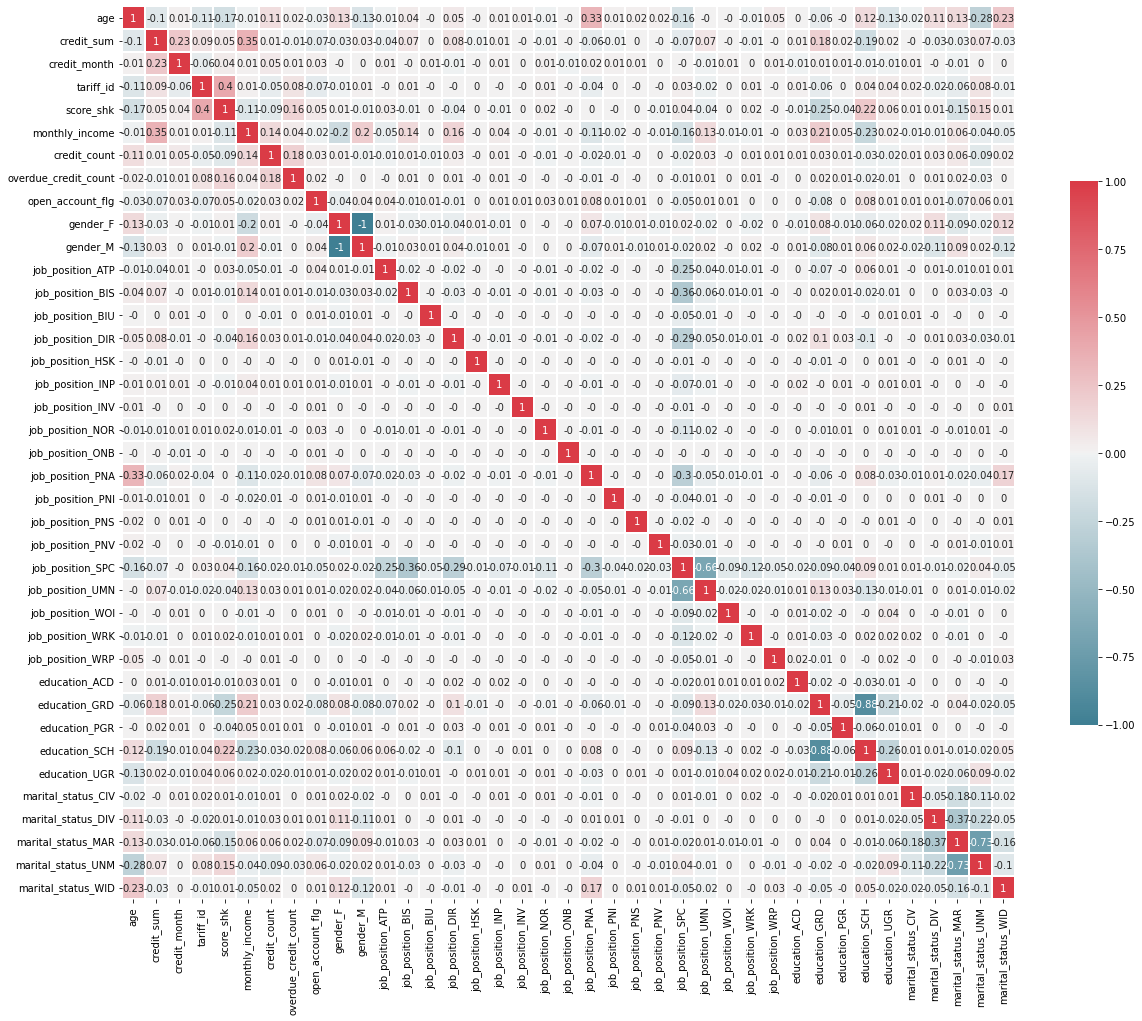

In [4]:
corr = data.corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

In [4]:
print('Признаки, имеющие максимальную по модулю корреляцию с целевым признаком')
best_params = data.corr()['open_account_flg'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.02]
best_params

Признаки, имеющие максимальную по модулю корреляцию с целевым признаком


education_GRD         0.082371
education_SCH         0.078337
job_position_PNA      0.076889
credit_sum            0.072039
tariff_id             0.067346
marital_status_MAR    0.067112
marital_status_UNM    0.061312
job_position_SPC      0.049143
score_shk             0.048686
gender_F              0.044265
gender_M              0.044265
job_position_ATP      0.038288
credit_count          0.032374
age                   0.031062
job_position_NOR      0.027320
credit_month          0.025809
monthly_income        0.023697
Name: open_account_flg, dtype: float64

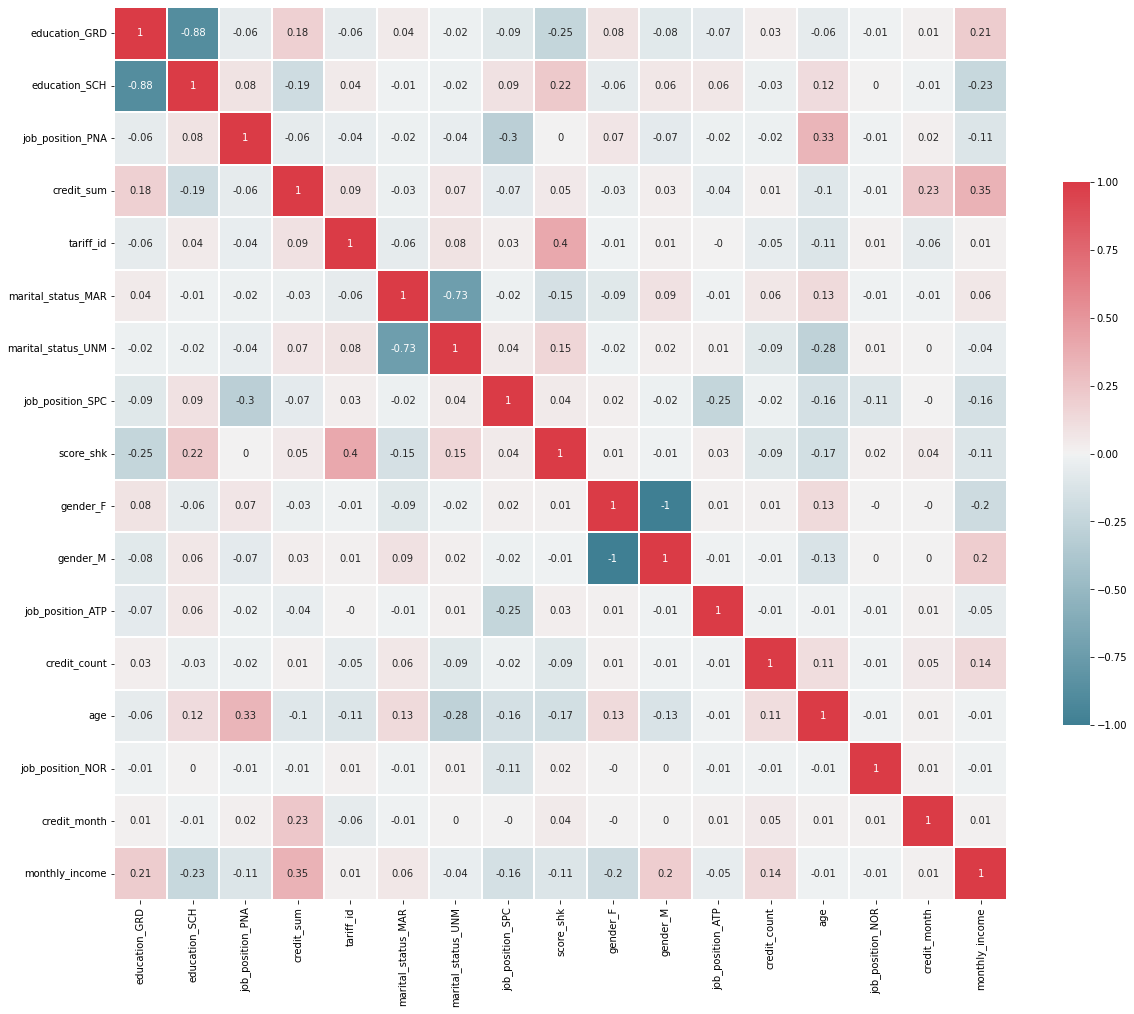

In [5]:
corr = data[best_params.index].corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

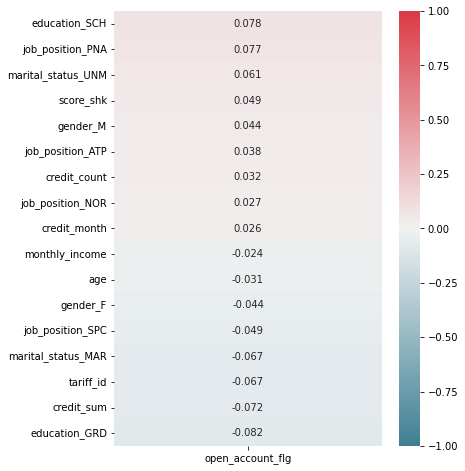

In [7]:
plt.figure(figsize=(6, 8))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'open_account_flg')].corr()['open_account_flg'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap=cmap, annot=True)
plt.show()

## 2) Разделение выборки на обучающую и тестовую

In [6]:
data_best = data[best_params.index]
data_best.head()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
0,1,0,0,59998.00,1.6,1,0,0,0.461599,0,1,0,1.0,34.0,0,10,30000.0
1,0,1,0,10889.00,1.1,1,0,0,0.461599,1,0,0,2.0,34.0,0,6,35000.0
2,0,1,0,10728.00,1.1,1,0,1,0.461599,0,1,0,5.0,32.0,0,12,35000.0
3,0,1,0,12009.09,1.1,1,0,1,0.461599,1,0,0,2.0,27.0,0,12,35000.0
4,0,1,0,21229.00,1.1,1,0,1,0.421385,0,1,0,1.0,45.0,0,10,35000.0


In [7]:
y = data['open_account_flg']
#X = data.drop('open_account_flg', axis=1)
X = data_best
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=21)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=21)

## 3) Масштабирование данных

In [8]:
scaler = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train.describe()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
count,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000
mean,0.425000,0.514759,0.023561,0.117340,0.345539,0.549665,0.304518,0.787651,0.404031,0.521452,0.478548,0.015663,0.117555,0.348769,0.003648,0.242378,0.062588
std,0.494351,0.499790,0.151679,0.082275,0.252486,0.497536,0.460211,0.408978,0.129396,0.499548,0.499548,0.124169,0.096737,0.198402,0.060289,0.108435,0.044938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.060249,0.106383,0.000000,0.000000,1.000000,0.310565,0.000000,0.000000,0.000000,0.055556,0.188679,0.000000,0.212121,0.034926
50%,0.000000,1.000000,0.000000,0.092536,0.340426,1.000000,0.000000,1.000000,0.396125,1.000000,0.000000,0.000000,0.111111,0.301887,0.000000,0.212121,0.053309
75%,1.000000,1.000000,0.000000,0.148270,0.638298,1.000000,1.000000,1.000000,0.490279,1.000000,1.000000,0.000000,0.166667,0.471698,0.000000,0.272727,0.080882
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4)  Модель №1: Случайный лес

In [11]:
def print_metrics(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-measure: {f1_score(y_test, y_pred)}")

In [12]:
print_metrics(y_test, RandomForestClassifier(random_state=17).fit(x_train, y_train).predict(x_test))

Accuracy: 0.8168827112291114
Precision: 0.4737991266375546
Recall: 0.0934941835415769
F1-measure: 0.15617128463476068


## Подбор гиперпараметров

In [14]:
rf = RandomForestClassifier(random_state=17)
params = {'n_estimators': [100, 1000], 
          'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=rf, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 1000}


In [15]:
best_rf = grid_cv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred_rf = best_rf.predict(x_test)
print_metrics(y_test, y_pred_rf)

Accuracy: 0.8209433078244572
Precision: 0.5752688172043011
Recall: 0.046100818612666954
F1-measure: 0.08536098923015557


## 5) Модель №2: Градиентный бустинг

In [16]:
print_metrics(y_test, GradientBoostingClassifier(random_state=17).fit(x_train, y_train).predict(x_test))

Accuracy: 0.8218803685772295
Precision: 0.5819672131147541
Recall: 0.06118052563550194
F1-measure: 0.11072124756335285


## Подбор гиперпараметров

In [22]:
gb = GradientBoostingClassifier(random_state=17)
params = {'n_estimators': [10, 50, 100, 200], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=gb, cv=5, param_grid=params, n_jobs=-1, scoring='f1')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 5, 'n_estimators': 200}


In [23]:
best_gb = grid_cv.best_estimator_
best_gb.fit(x_train, y_train)
y_pred_gb = best_gb.predict(x_test)
print_metrics(y_test, y_pred_gb)

Accuracy: 0.8223488989536155
Precision: 0.5709876543209876
Recall: 0.07970702283498492
F1-measure: 0.13988657844990549


## 6) Модель №3: Стекинг

In [24]:
dataset = Dataset(x_train, y_train, x_test)

In [38]:
model_lr = Classifier(dataset=dataset, estimator=LogisticRegression, name='lr')
model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, 
                     parameters={'n_estimators': 1000, 'random_state': 17}, name='rf')
model_gb = Classifier(dataset=dataset, estimator=GradientBoostingClassifier, 
                     parameters={'random_state': 17}, name='gb')

In [50]:
pipeline = ModelsPipeline(model_lr, model_gb, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
stacker = Classifier(dataset=stack_ds, estimator=RandomForestClassifier)

In [55]:
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [0.2521619812583668, 0.25059236947791164, 0.2636479250334672, 0.25539825970548863, 0.25099397590361444, 0.24829317269076304, 0.25420682730923694, 0.25118808567603745, 0.2488420348058902, 0.24493975903614457]
Mean accuracy: 0.25202643908969213
Standard Deviation: 0.004788785748303347
Variance: 2.2932468943153247e-05


In [54]:
p_pred = stacker.predict() 
y_pred_stack = np.where(p_pred > 0.5, 1, 0)
print_metrics(y_test, y_pred_stack)

Accuracy: 0.8071997501171326
Precision: 0.40488431876606684
Recall: 0.13571736320551486
F1-measure: 0.20329138431752175


## 7) Модель №4: Многослойный персептрон

In [32]:
print_metrics(y_test, MLPClassifier(random_state=17).fit(x_train, y_train).predict(x_test))

Accuracy: 0.8197719818834921
Precision: 0.5241635687732342
Recall: 0.06074967686342094
F1-measure: 0.10888030888030888


## Подбор гиперпараметров

In [9]:
mlp = MLPClassifier(random_state=17)
params = {'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(15,), (30, 15,), (40, 20,)], 
          'alpha': [1e-4, 3e-4, 5e-4], 'max_iter': [500]} #, 'max_iter': [500, 1000]
grid_cv = GridSearchCV(estimator=mlp, cv=5, param_grid=params, n_jobs=-1, scoring='f1')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'alpha': 0.0003, 'hidden_layer_sizes': (40, 20), 'max_iter': 500, 'solver': 'adam'}


In [12]:
best_mlp = grid_cv.best_estimator_
best_mlp.fit(x_train, y_train)
y_pred_mlp = best_mlp.predict(x_test)
print_metrics(y_test, y_pred_mlp)

Accuracy: 0.818600655942527
Precision: 0.49760765550239233
Recall: 0.08961654459284792
F1-measure: 0.15188024826579044


## Модель №5: Метод группового учёта аргументов

In [36]:
gm = gmdh.Classifier(n_jobs=-1)
gm.fit(np.array(x_train), np.array(y_train))
y_pred_gm = gm.predict(np.array(x_test))
print()
print_metrics(y_test, y_pred_gm)

train layer0 in 3.98 sec
train layer1 in 32.10 sec
train layer2 in 33.37 sec
train layer3 in 34.87 sec
train layer4 in 33.18 sec
train layer5 in 33.97 sec


ValueError: y should be a 1d array, got an array of shape () instead.

## Сравнение моделей

In [56]:
print("Случайный лес")
print_metrics(y_test, y_pred_rf)

print("\nГрадиентный бустинг")
print_metrics(y_test, y_pred_gb)

print("\nСтекинг")
print_metrics(y_test, y_pred_stack)

print("\nМногослойный персептрон")
print_metrics(y_test, y_pred_mlp)

print("\nМетод группового учёта аргументов")
#print_metrics(y_test, y_pred_gm)

Случайный лес
Accuracy: 0.8209433078244572
Precision: 0.5752688172043011
Recall: 0.046100818612666954
F1-measure: 0.08536098923015557

Градиентный бустинг
Accuracy: 0.8223488989536155
Precision: 0.5709876543209876
Recall: 0.07970702283498492
F1-measure: 0.13988657844990549

Стекинг
Accuracy: 0.8071997501171326
Precision: 0.40488431876606684
Recall: 0.13571736320551486
F1-measure: 0.20329138431752175

Многослойный персептрон
Accuracy: 0.8200843354677495
Precision: 0.5242165242165242
Recall: 0.07927617406290392
F1-measure: 0.1377245508982036

Метод группового учёта аргументов
